In [38]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator
import itertools

- Import and process the data
- Create a plot of polarization over time

<Axes: title={'center': 'Polarization Over Time'}, xlabel='Datetime', ylabel='Polarization'>

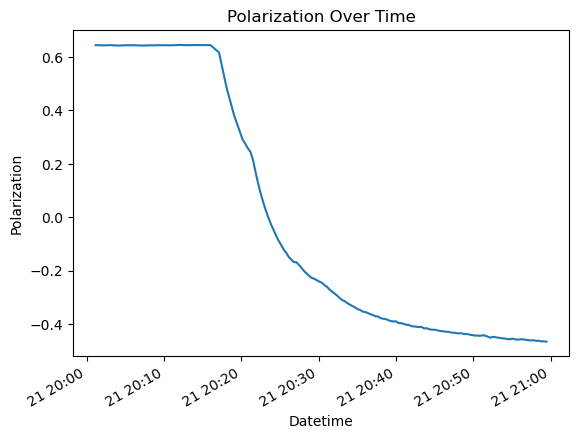

In [39]:
with open("FIXED_2022-06-21_23.txt","r") as eventfile:
    df = pd.read_json(eventfile, lines=True)
df['stop_time'] = pd.to_datetime(df['stop_time'])
df.set_index('stop_time', inplace=True)

# Plot the polarization over time
df['pol'].plot(title='Polarization Over Time',
                      xlabel='Datetime',
                      ylabel='Polarization')

- Create time, fit, and area lists to use for later

In [47]:
# Make Time_steps list
time = df['pol'].index

# Store fit results
fit_results = {}
previous_fit_params = None
last_good_params = None

# Store area results
area_results = []

### Define Single Gaussian & Three Gaussians
- $A \exp\left(-\frac{(x-c)^2}{2w^2}\right)$
- Where A = amplitude, c = center, w = width

In [48]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x,
                    amp1, cen1, wid1,
                    amp2, cen2, wid2,
                    amp3, cen3, wid3):
    g1 = gaussian(x, amp1, cen1, wid1)
    g2 = gaussian(x, amp2, cen2, wid2)
    g3 = gaussian(x, amp3, cen3, wid3)
    return g1 + g2 + g3

### 3 Gaussian Fitting For Signal Slider

In [55]:
# === Fitting + plotting function ===
def plot_pol_array_with_fit(index):
    signal_array = np.array(df.iloc[index]['rescurve'])  # ensure numpy
    x_data = np.arange(len(signal_array))
    mean_val = np.mean(signal_array)

    # --- Decide initial guess ---
    if index == 0 or (index-1 not in fit_results):
        # Base case: use evenly spaced initial guess
        amp_left   = mean_val / 3
        cen_left   = len(signal_array) / 4
        wid_left   = 100

        amp_center = mean_val / 3
        cen_center = len(signal_array) / 2
        wid_center = 100

        amp_right  = mean_val / 3
        cen_right  = 3 * len(signal_array) / 4
        wid_right  = 100

        initial_guess = [
            amp_left, cen_left, wid_left,
            amp_center, cen_center, wid_center,
            amp_right, cen_right, wid_right
        ]
    else:
        # Use previous row’s results
        initial_guess = fit_results[index-1]["params"]

    try:
        # Perform fit
        popt, pcov = curve_fit(
            three_gaussians,
            x_data,
            signal_array,
            p0=initial_guess,
            maxfev=10000
        )

        # --- Sort Gaussians by center ---
        params = [
            (popt[0], popt[1], popt[2]),  # Gaussian 1
            (popt[3], popt[4], popt[5]),  # Gaussian 2
            (popt[6], popt[7], popt[8])   # Gaussian 3
        ]
        params_sorted = sorted(params, key=lambda x: x[1])  # sort by center
        amp_left, cen_left, wid_left   = params_sorted[0]
        amp_center, cen_center, wid_center = params_sorted[1]
        amp_right, cen_right, wid_right   = params_sorted[2]

        popt_sorted = [
            amp_left, cen_left, wid_left,
            amp_center, cen_center, wid_center,
            amp_right, cen_right, wid_right
        ]

        # --- Save result for this index ---
        fit_results[index] = {
            "index": index,
            "time": df.index[index],
            "pol": df.iloc[index]["pol"],
            "params": popt_sorted
        }

        # --- Plotting ---
        plt.figure(figsize=(10, 6))
        plt.plot(x_data, signal_array, 'k', lw=2, label='Original Signal')
        plt.plot(x_data, three_gaussians(x_data, *popt_sorted),
                 '--r', lw=2, label='Total Fit')

        g_left   = gaussian(x_data, amp_left,   cen_left,   wid_left)
        g_center = gaussian(x_data, amp_center, cen_center, wid_center)
        g_right  = gaussian(x_data, amp_right,  cen_right,  wid_right)

        plt.plot(x_data, g_center,   ':', color='tab:blue',   lw=2, label='Left Gaussian')
        plt.plot(x_data, g_left, ':', color='tab:green',  lw=2, label='Center Gaussian')
        plt.plot(x_data, g_right,  ':', color='tab:orange', lw=2, label='Right Gaussian')

        plt.title(f"Row {index} | Polarization = {df.iloc[index]['pol']:.3f}")
        plt.xlabel("Index")
        plt.ylabel("Signal")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    except RuntimeError:
        print(f"Fit failed for row {index}")


- Creates the Signal Slider, lets us see how Gaussians evolve with different row index values

In [ ]:
interact(
    plot_pol_array_with_fit,
    index=IntSlider(min=0, max=len(df)-1, step=1, value=0, description='Row Index:')
)

interactive(children=(IntSlider(value=0, description='Row Index:', max=138), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array_with_fit(index)>

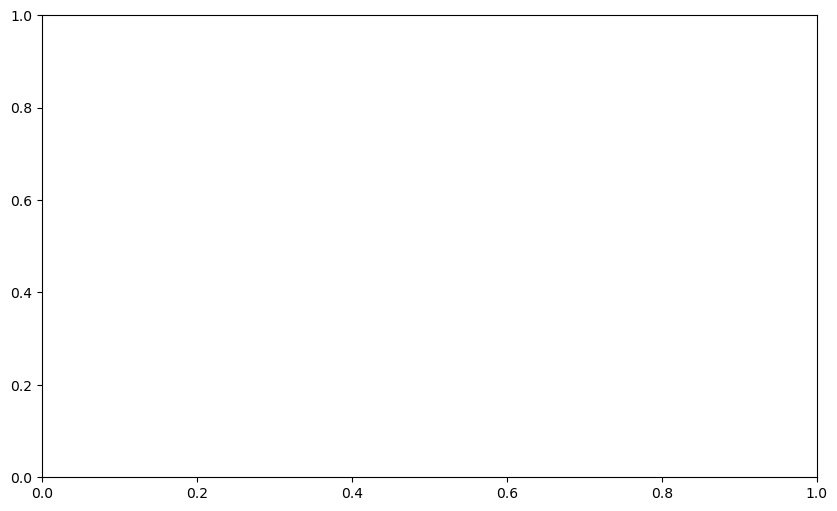

In [58]:
# Pre-fill fit_results for ALL rows if not already cached
for idx in range(len(df)):
    if idx not in fit_results:
        try:
            plot_pol_array_with_fit(idx)  # runs the fitting + stores in dict
            plt.close()  # prevent individual plots popping up
        except RuntimeError:
            print(f"Skipping row {idx} (fit failed)")

# Animation
fig, ax = plt.subplots(figsize=(10, 6))

def init():
    ax.clear()
    return []

def update(i):
    ax.clear()
    fr = fit_results[i]
    signal_array = np.array(df.iloc[fr['index']]['rescurve'])
    x_data = np.arange(len(signal_array))

    # Original signal
    ax.plot(x_data, signal_array, 'k', lw=1.5, label='Original Signal')

    # Total fit
    popt = fr['params']
    ax.plot(x_data, three_gaussians(x_data, *popt),
            '--', color='red', lw=2, label='Total Fit')

    # Individual Gaussians
    colors = ['tab:green', 'tab:blue', 'tab:orange']
    labels = ['Center Gaussian', 'Left Gaussian', 'Right Gaussian']
    for j, (col, lab) in enumerate(zip(colors, labels)):
        amp, cen, wid = popt[j*3:j*3+3]
        g = gaussian(x_data, amp, cen, wid)
        ax.plot(x_data, g, ':', color=col, lw=2, label=lab)

    ax.set_title(f"Row {fr['index']} | Polarization = {fr['pol']:.3f}")
    ax.set_xlabel("Index")
    ax.set_ylabel("Signal")
    ax.grid(alpha=0.3)
    ax.legend()
    return []

ani = FuncAnimation(
    fig, update, frames=range(len(fit_results)),
    init_func=init, blit=False, repeat=False
)

#ani.save("NEW_FIT_NMRSignal_PosToNegPol.gif", writer=PillowWriter(fps=5))
#plt.close(fig)
#print("GIF saved as NEW_FIT_NMRSignal_PosToNegPol.gif")

### 3 Gaussian Fitting for Parameter Plotting

In [ ]:
# Set bounds
lowbound = (-np.inf, -np.inf, 0, -np.inf, -np.inf, 0, -np.inf, -np.inf, 0)
upbound  = ( np.inf,  np.inf, np.inf,  np.inf,  np.inf, np.inf,  np.inf,  np.inf,  np.inf)

# Make list to store results
fit_results = []

# Looping through the signal curves
for i in range(len(df)):
    y = df.iloc[i]['rescurve']
    x = np.arange(len(y))

    # Initial Guess
    mean_val = np.mean(y)
    L0, C0, R0 = len(y)/4, len(y)/2, 3*len(y)/4
    initial_guess = [
        mean_val/3, L0, 100,
        mean_val/3, C0, 100,
        mean_val/3, R0, 100
    ]

    try:
        #  Perform Three Guassian Fit
        popt, pcov = curve_fit(
            three_gaussians, x, y,
            p0=initial_guess, bounds=(lowbound, upbound), maxfev=10000
        )
        perr = np.sqrt(np.diag(pcov))
        
        # Store each Gaussian's parameter's into dicts (+ areas)
        fitted = [
            {
                'amp': popt[0], 'cen': popt[1], 'wid': popt[2],
                'amp_err': perr[0], 'cen_err': perr[1], 'wid_err': perr[2],
                'area': (popt[0] * popt[2]) / 0.3989 if popt[0] != 0 and popt[2] != 0 else np.nan,
                'area_err': ((popt[0] * popt[2]) / 0.3989) * np.sqrt((perr[0]/popt[0])**2 + (perr[2]/popt[2])**2)
                            if popt[0] != 0 and popt[2] != 0 else np.nan
            },
            {
                'amp': popt[3], 'cen': popt[4], 'wid': popt[5],
                'amp_err': perr[3], 'cen_err': perr[4], 'wid_err': perr[5],
                'area': (popt[3] * popt[5]) / 0.3989 if popt[3] != 0 and popt[5] != 0 else np.nan,
                'area_err': ((popt[3] * popt[5]) / 0.3989) * np.sqrt((perr[3]/popt[3])**2 + (perr[5]/popt[5])**2)
                            if popt[3] != 0 and popt[5] != 0 else np.nan
            },
            {
                'amp': popt[6], 'cen': popt[7], 'wid': popt[8],
                'amp_err': perr[6], 'cen_err': perr[7], 'wid_err': perr[8],
                'area': (popt[6] * popt[8]) / 0.3989 if popt[6] != 0 and popt[8] != 0 else np.nan,
                'area_err': ((popt[6] * popt[8]) / 0.3989) * np.sqrt((perr[6]/popt[6])**2 + (perr[8]/popt[8])**2)
                            if popt[6] != 0 and popt[8] != 0 else np.nan
            }
        ]

        # Match fitted Gaussians to left/center/right
        L0, C0, R0 = len(y)/4, len(y)/2, 3*len(y)/4
        seed_centers = [L0, C0, R0]
        fitted_centers = [g['cen'] for g in fitted]

        perms = list(itertools.permutations(range(3)))
        best_perm = min(
            perms,
            key=lambda p: abs(fitted_centers[p[0]]-seed_centers[0]) +
                  abs(fitted_centers[p[1]]-seed_centers[1]) +
                  abs(fitted_centers[p[2]]-seed_centers[2])
        )

        center_gauss, left_gauss, right_gauss = [fitted[i] for i in best_perm]

        # Compute chi² of fit
        model = three_gaussians(x, *popt)
        resid = y - model
        sigma = np.std(resid, ddof=1)
        if sigma <= 0 or np.isnan(sigma):
            continue
        chi2 = np.sum((resid/sigma)**2)
        dof = len(y) - len(popt)
        red_chi2 = chi2/dof if dof>0 else np.nan

        # --- Store everything ---
        fit_results.append({
            'index': i,
            'time': df.index[i],
            'pol': df.iloc[i]['pol'],
            'left': left_gauss,
            'center': center_gauss,
            'right': right_gauss,
            'params': popt,
            'errors': perr,
            'chi2': chi2,
            'reduced_chi2': red_chi2
        })

    except RuntimeError:
        continue

# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

- Printing the $\chi^2$ and Reduced $\chi^2$ values to see how good the fit was

In [ ]:
print(fit_df[['time', 'chi2']])
print(fit_df[['time', 'reduced_chi2']])

                                time        chi2
0   2022-06-21 20:01:07.365417+00:00  513.108614
1   2022-06-21 20:02:06.772140+00:00  514.064581
2   2022-06-21 20:03:06.178840+00:00  514.534852
3   2022-06-21 20:04:05.588331+00:00  513.643197
4   2022-06-21 20:05:04.995001+00:00  515.135978
..                               ...         ...
134 2022-06-21 20:58:09.107866+00:00  511.904391
135 2022-06-21 20:58:28.919766+00:00  512.234935
136 2022-06-21 20:58:48.731356+00:00  511.339454
137 2022-06-21 20:59:08.543640+00:00  512.794162
138 2022-06-21 20:59:28.367869+00:00  512.077450

[139 rows x 2 columns]
                                time  reduced_chi2
0   2022-06-21 20:01:07.365417+00:00      1.020097
1   2022-06-21 20:02:06.772140+00:00      1.021997
2   2022-06-21 20:03:06.178840+00:00      1.022932
3   2022-06-21 20:04:05.588331+00:00      1.021159
4   2022-06-21 20:05:04.995001+00:00      1.024127
..                               ...           ...
134 2022-06-21 20:58:09.107866+

### Gaussian Amplitude vs Time Plot

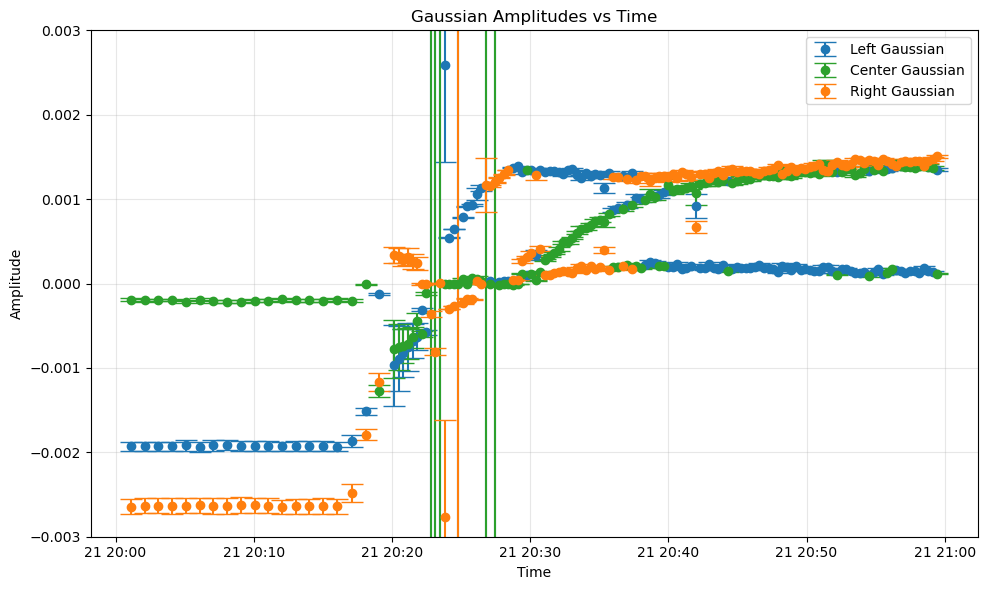

In [ ]:
plt.figure(figsize=(10, 6))

# Left Gaussian
amps_left = fit_df['left'].apply(lambda d: d['amp'])
amp_errs_left = fit_df['left'].apply(lambda d: d['amp_err'])
plt.errorbar(fit_df['time'], amps_left, yerr=amp_errs_left,
             fmt='o', capsize=8, color='tab:blue', label='Left Gaussian')

# Center Gaussian
amps_center = fit_df['center'].apply(lambda d: d['amp'])
amp_errs_center = fit_df['center'].apply(lambda d: d['amp_err'])
plt.errorbar(fit_df['time'], amps_center, yerr=amp_errs_center,
             fmt='o', capsize=8, color='tab:green', label='Center Gaussian')

# Right Gaussian
amps_right = fit_df['right'].apply(lambda d: d['amp'])
amp_errs_right = fit_df['right'].apply(lambda d: d['amp_err'])
plt.errorbar(fit_df['time'], amps_right, yerr=amp_errs_right,
             fmt='o', capsize=8, color='tab:orange', label='Right Gaussian')

# Plot Format
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Gaussian Amplitudes vs Time")
plt.ylim(-0.003, 0.003)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Gaussian Centers vs Time Plot

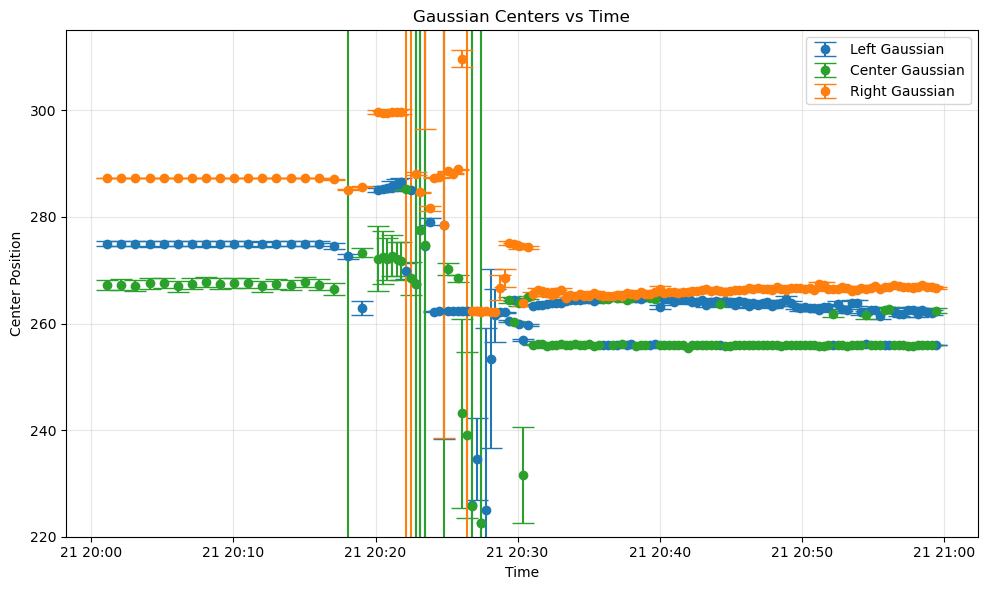

In [ ]:
plt.figure(figsize=(10, 6))

# Left Gaussian
centers_left = fit_df['left'].apply(lambda d: d['cen'])
centers_err_left = fit_df['left'].apply(lambda d: d['cen_err'])
plt.errorbar(fit_df['time'], centers_left, yerr=centers_err_left,
             fmt='o', capsize=8, color='tab:blue', label='Left Gaussian')

# Center Gaussian
centers_center = fit_df['center'].apply(lambda d: d['cen'])
centers_err_center = fit_df['center'].apply(lambda d: d['cen_err'])
plt.errorbar(fit_df['time'], centers_center, yerr=centers_err_center,
             fmt='o', capsize=8, color='tab:green', label='Center Gaussian')

# Right Gaussian
centers_right = fit_df['right'].apply(lambda d: d['cen'])
centers_err_right = fit_df['right'].apply(lambda d: d['cen_err'])
plt.errorbar(fit_df['time'], centers_right, yerr=centers_err_right,
             fmt='o', capsize=8, color='tab:orange', label='Right Gaussian')

# Plot Format
plt.xlabel("Time")
plt.ylabel("Center Position")
plt.title("Gaussian Centers vs Time")
plt.legend()
plt.ylim(220, 315)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Gaussian Widths vs Time Plot

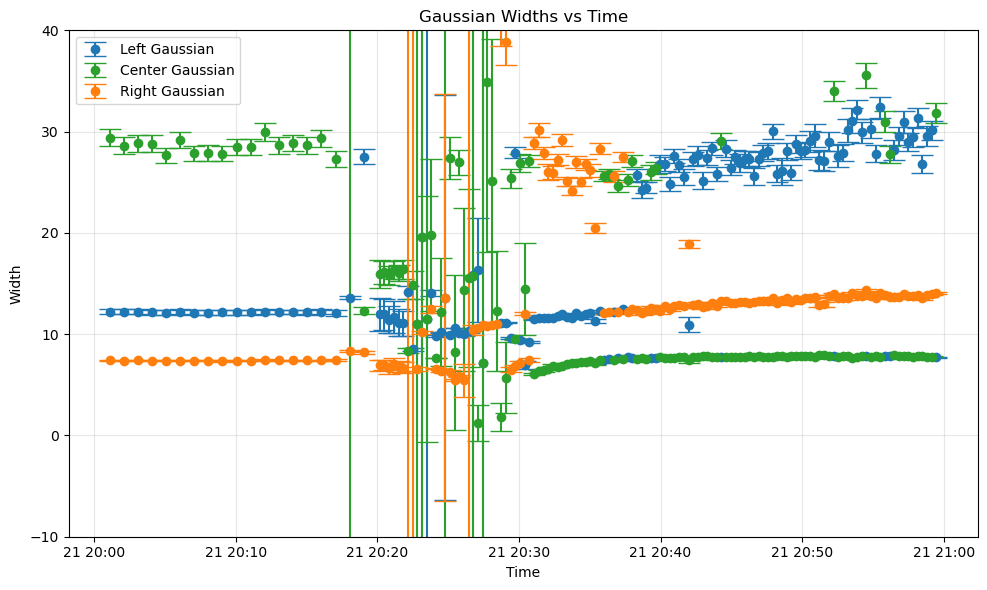

In [ ]:
plt.figure(figsize=(10, 6))

# Left Gaussian
widths_left = fit_df['left'].apply(lambda d: d['wid'])
widths_err_left = fit_df['left'].apply(lambda d: d['wid_err'])
plt.errorbar(fit_df['time'], widths_left, yerr=widths_err_left,
             fmt='o', capsize=8, color='tab:blue', label='Left Gaussian')

# Center Gaussian
widths_center = fit_df['center'].apply(lambda d: d['wid'])
widths_err_center = fit_df['center'].apply(lambda d: d['wid_err'])
plt.errorbar(fit_df['time'], widths_center, yerr=widths_err_center,
             fmt='o', capsize=8, color='tab:green', label='Center Gaussian')

# Right Gaussian
widths_right = fit_df['right'].apply(lambda d: d['wid'])
widths_err_right = fit_df['right'].apply(lambda d: d['wid_err'])
plt.errorbar(fit_df['time'], widths_right, yerr=widths_err_right,
             fmt='o', capsize=8, color='tab:orange', label='Right Gaussian')

# Plot Format
plt.xlabel("Time")
plt.ylabel("Width")
plt.title("Gaussian Widths vs Time")
plt.legend()
plt.ylim(-10, 40)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Gaussian Areas vs Time Plot

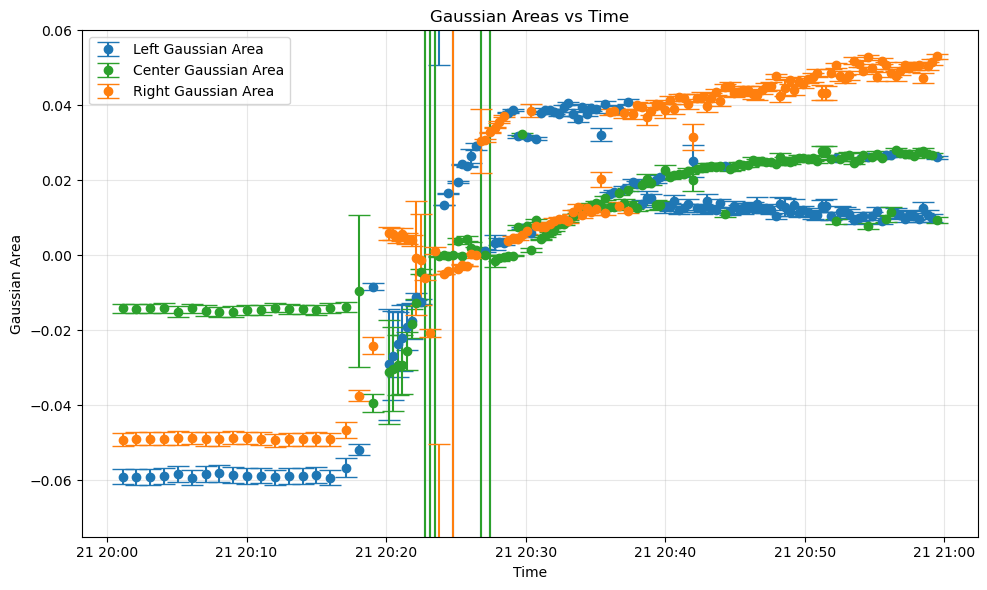

In [ ]:
plt.figure(figsize=(10, 6))

# Left Gaussian
areas_left = fit_df['left'].apply(lambda d: d.get('area', np.nan))
area_errs_left = fit_df['left'].apply(lambda d: np.abs(d.get('area_err', np.nan)))
plt.errorbar(fit_df['time'], areas_left, yerr=area_errs_left,
             fmt='o', capsize=8, color='tab:blue', label='Left Gaussian Area')

# Center Gaussian
areas_center = fit_df['center'].apply(lambda d: d.get('area', np.nan))
area_errs_center = fit_df['center'].apply(lambda d: np.abs(d.get('area_err', np.nan)))
plt.errorbar(fit_df['time'], areas_center, yerr=area_errs_center,
             fmt='o', capsize=8, color='tab:green', label='Center Gaussian Area')

# Right Gaussian
areas_right = fit_df['right'].apply(lambda d: d.get('area', np.nan))
area_errs_right = fit_df['right'].apply(lambda d: np.abs(d.get('area_err', np.nan)))
plt.errorbar(fit_df['time'], areas_right, yerr=area_errs_right,
             fmt='o', capsize=8, color='tab:orange', label='Right Gaussian Area')

# Plot Format
plt.xlabel("Time")
plt.ylabel("Gaussian Area")
plt.title("Gaussian Areas vs Time")
plt.legend()
plt.ylim(-0.075, 0.06)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

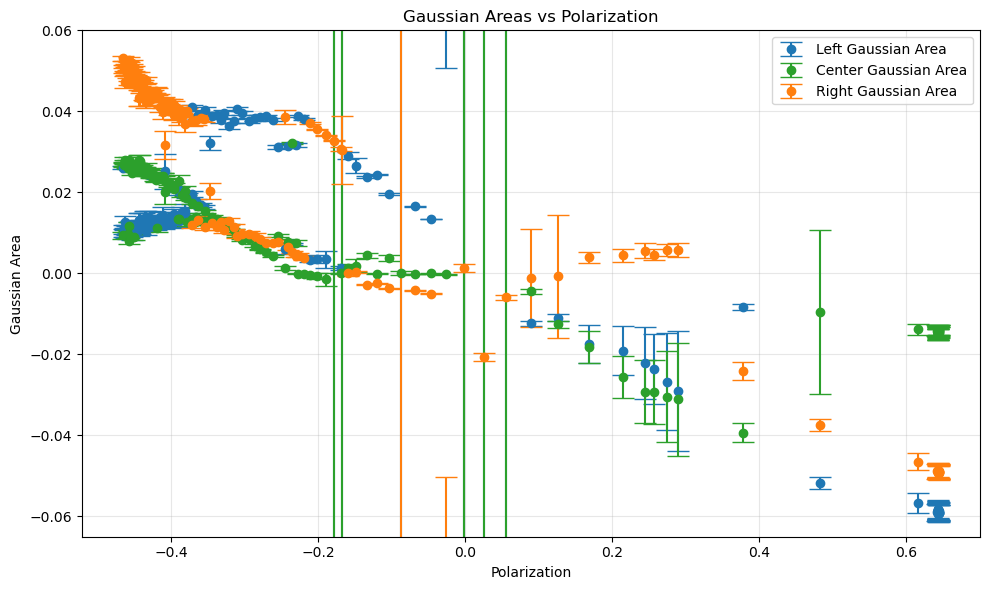

In [ ]:
plt.figure(figsize=(10, 6))

# Left Gaussian
areas_left = fit_df['left'].apply(lambda d: d.get('area', np.nan))
area_errs_left = fit_df['left'].apply(lambda d: np.abs(d.get('area_err', np.nan)))
plt.errorbar(fit_df['pol'], areas_left, yerr=area_errs_left,
             fmt='o', capsize=8, color='tab:blue', label='Left Gaussian Area')

# Center Gaussian
areas_center = fit_df['center'].apply(lambda d: d.get('area', np.nan))
area_errs_center = fit_df['center'].apply(lambda d: np.abs(d.get('area_err', np.nan)))
plt.errorbar(fit_df['pol'], areas_center, yerr=area_errs_center,
             fmt='o', capsize=8, color='tab:green', label='Center Gaussian Area')

# Right Gaussian
areas_right = fit_df['right'].apply(lambda d: d.get('area', np.nan))
area_errs_right = fit_df['right'].apply(lambda d: np.abs(d.get('area_err', np.nan)))
plt.errorbar(fit_df['pol'], areas_right, yerr=area_errs_right,
             fmt='o', capsize=8, color='tab:orange', label='Right Gaussian Area')

# Plot Format
plt.xlabel("Polarization")
plt.ylabel("Gaussian Area")
plt.title("Gaussian Areas vs Polarization")
plt.legend()
plt.ylim(-0.065, 0.06)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print("Negative pol points:", ((fit_df['pol'] < 0) & ~fit_df['left'].apply(lambda d: np.isnan(d.get('area', np.nan)))).sum())
print("Positive pol points:", ((fit_df['pol'] > 0) & ~fit_df['left'].apply(lambda d: np.isnan(d.get('area', np.nan)))).sum())


Negative pol points: 110
Positive pol points: 29


In [ ]:
### OG SLIDER FITTING

def plot_pol_array_with_fit(index):

    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']    # Extract the signal
    x_data = np.arange(len(signal_array))        # Index positions of the signal for x-axis

    # --- INITIAL PARAMETERS FOR THE THREE PEAKS ---
    mean_val = np.mean(signal_array)
    L0 = len(signal_array) / 4     # Left peak
    C0 = len(signal_array) / 2     # Center peak
    R0 = 3 * len(signal_array) / 4 # Right peak 
    initial_guess = [
        mean_val / 3, L0, 100,     # Left: amp guess, center guess, width guess
        mean_val / 3, C0, 100,     # Center: ...
        mean_val / 3, R0, 100      # Right: ...
    ]

    try:
        # --- FITTING ---
        # popt: optimized parameter values (amplitude, center, width for each Gaussian)
        # pcov: covariance matrix of the fit, for calculating errors
        popt, pcov = curve_fit(
            three_gaussians, x_data, signal_array,
            p0=initial_guess, maxfev=10000
        )
        perr = np.sqrt(np.diag(pcov))  # Errors of fitted parameters

        # Create a dict for each Gaussian with amplitude, center, width, and their errors
        g0 = {'amp': popt[0], 'cen': popt[1], 'wid': popt[2],
              'amp_err': perr[0], 'cen_err': perr[1], 'wid_err': perr[2]}
        g1 = {'amp': popt[3], 'cen': popt[4], 'wid': popt[5],
              'amp_err': perr[3], 'cen_err': perr[4], 'wid_err': perr[5]}
        g2 = {'amp': popt[6], 'cen': popt[7], 'wid': popt[8],
              'amp_err': perr[6], 'cen_err': perr[7], 'wid_err': perr[8]}
        fitted = [g0, g1, g2]

        # --- MATCH FITTED PEAKS TO INITIAL GUESSES (L, C, R) ---
        fitted_centers = [g['cen'] for g in fitted]
        seed_centers = [L0, C0, R0]

       # Match fitted Gaussians to left/center/right by testing all permutations
       # and picking the order whose centers are closest to the initial seed guesses.
        perms = list(itertools.permutations(range(3)))
        best_perm = min(
            perms,
            key=lambda p: abs(fitted_centers[p[0]] - seed_centers[0]) +
                          abs(fitted_centers[p[1]] - seed_centers[1]) +
                          abs(fitted_centers[p[2]] - seed_centers[2])
        )
        left_gauss, center_gauss, right_gauss = [fitted[i] for i in best_perm]

        # --- PRINT PARAMETERS FOR EACH GAUSSIAN ---
        # --- Uncomment to see parameter values in slider ---
        #for name, g in (("Left Gaussian", left_gauss),
                        #("Center Gaussian", center_gauss),
                        #("Right Gaussian", right_gauss)):
            #print(f"{name}")
            #print(f"  Amplitude = {g['amp']:.4f} ± {g['amp_err']:.4f}")
            #print(f"  Center    = {g['cen']:.2f} ± {g['cen_err']:.2f}")
            #print(f"  Width     = {g['wid']:.2f} ± {g['wid_err']:.2f}\n")

        # --- STORE RESULTS IN LISTs ---
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'left': left_gauss,
            'center': center_gauss,
            'right': right_gauss
        })

        # --- PLOT EVERYTHING ---
        plt.plot(x_data, signal_array, color='tab:blue', label='Original Signal', linewidth=2)
        plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

        # Plot individual Gaussians
        plt.plot(x_data, gaussian(x_data, left_gauss['amp'], left_gauss['cen'], left_gauss['wid']),
                 linestyle=':', color='tab:blue', label='Left Gaussian')
        plt.plot(x_data, gaussian(x_data, center_gauss['amp'], center_gauss['cen'], center_gauss['wid']),
                 linestyle=':', color='tab:green', label='Center Gaussian')
        plt.plot(x_data, gaussian(x_data, right_gauss['amp'], right_gauss['cen'], right_gauss['wid']),
                 linestyle=':', color='tab:orange', label='Right Gaussian')

        plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
        plt.xlabel("Index")
        plt.ylabel("Signal")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    except RuntimeError:
        print(f"Fit failed for row {index}")

# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

In [ ]:
### OG PLOTTING FITTING

# Set bounds
lowbound = (-np.inf, -np.inf, 0, -np.inf, -np.inf, 0, -np.inf, -np.inf, 0)
upbound  = ( np.inf,  np.inf, np.inf,  np.inf,  np.inf, np.inf,  np.inf,  np.inf,  np.inf)

# Make list to store results
fit_results = []

# Looping through the signal curves
for i in range(len(df)):
    y = df.iloc[i]['rescurve']
    x = np.arange(len(y))

    # Initial Guess
    mean_val = np.mean(y)
    L0, C0, R0 = len(y)/4, len(y)/2, 3*len(y)/4
    initial_guess = [
        mean_val/3, L0, 100,
        mean_val/3, C0, 100,
        mean_val/3, R0, 100
    ]

    try:
        #  Perform Three Guassian Fit
        popt, pcov = curve_fit(
            three_gaussians, x, y,
            p0=initial_guess, bounds=(lowbound, upbound), maxfev=10000
        )
        perr = np.sqrt(np.diag(pcov))
        
        # Store each Gaussian's parameter's into dicts (+ areas)
        fitted = [
            {
                'amp': popt[0], 'cen': popt[1], 'wid': popt[2],
                'amp_err': perr[0], 'cen_err': perr[1], 'wid_err': perr[2],
                'area': (popt[0] * popt[2]) / 0.3989 if popt[0] != 0 and popt[2] != 0 else np.nan,
                'area_err': ((popt[0] * popt[2]) / 0.3989) * np.sqrt((perr[0]/popt[0])**2 + (perr[2]/popt[2])**2)
                            if popt[0] != 0 and popt[2] != 0 else np.nan
            },
            {
                'amp': popt[3], 'cen': popt[4], 'wid': popt[5],
                'amp_err': perr[3], 'cen_err': perr[4], 'wid_err': perr[5],
                'area': (popt[3] * popt[5]) / 0.3989 if popt[3] != 0 and popt[5] != 0 else np.nan,
                'area_err': ((popt[3] * popt[5]) / 0.3989) * np.sqrt((perr[3]/popt[3])**2 + (perr[5]/popt[5])**2)
                            if popt[3] != 0 and popt[5] != 0 else np.nan
            },
            {
                'amp': popt[6], 'cen': popt[7], 'wid': popt[8],
                'amp_err': perr[6], 'cen_err': perr[7], 'wid_err': perr[8],
                'area': (popt[6] * popt[8]) / 0.3989 if popt[6] != 0 and popt[8] != 0 else np.nan,
                'area_err': ((popt[6] * popt[8]) / 0.3989) * np.sqrt((perr[6]/popt[6])**2 + (perr[8]/popt[8])**2)
                            if popt[6] != 0 and popt[8] != 0 else np.nan
            }
        ]

        # Match fitted Gaussians to left/center/right
        L0, C0, R0 = len(y)/4, len(y)/2, 3*len(y)/4
        seed_centers = [L0, C0, R0]
        fitted_centers = [g['cen'] for g in fitted]

        perms = list(itertools.permutations(range(3)))
        best_perm = min(
            perms,
            key=lambda p: abs(fitted_centers[p[0]]-seed_centers[0]) +
                  abs(fitted_centers[p[1]]-seed_centers[1]) +
                  abs(fitted_centers[p[2]]-seed_centers[2])
        )

        center_gauss, left_gauss, right_gauss = [fitted[i] for i in best_perm]

        # Compute chi² of fit
        model = three_gaussians(x, *popt)
        resid = y - model
        sigma = np.std(resid, ddof=1)
        if sigma <= 0 or np.isnan(sigma):
            continue
        chi2 = np.sum((resid/sigma)**2)
        dof = len(y) - len(popt)
        red_chi2 = chi2/dof if dof>0 else np.nan

        # --- Store everything ---
        fit_results.append({
            'index': i,
            'time': df.index[i],
            'pol': df.iloc[i]['pol'],
            'left': left_gauss,
            'center': center_gauss,
            'right': right_gauss,
            'params': popt,
            'errors': perr,
            'chi2': chi2,
            'reduced_chi2': red_chi2
        })

    except RuntimeError:
        continue

# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)